In [1]:
import arkouda as ak
ak.connect() 

    _         _                   _       
   / \   _ __| | _____  _   _  __| | __ _ 
  / _ \ | '__| |/ / _ \| | | |/ _` |/ _` |
 / ___ \| |  |   < (_) | |_| | (_| | (_| |
/_/   \_\_|  |_|\_\___/ \__,_|\__,_|\__,_|
                                          

Client Version: v2023.02.08+420.g70ffd1cd1.dirty


/Users/ben.mcdonald/arkouda/arkouda/client.py:731: RuntimeWarning: Version mismatch between client (v2023.02.08+420.g70ffd1cd1.dirty) and server (v2023.02.08+419.g13d344a7b.dirty); this may cause some commands to fail or behave incorrectly! Updating arkouda is strongly recommended.
  warnings.warn(
connected to arkouda server tcp://*:5555


In [2]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import gc

## Read Parquet Taxi Cab Data

In [47]:
columns = ['VendorID',
           'lpep_pickup_datetime',
           'lpep_dropoff_datetime',
           'fare_amount',
           'PULocationID',
           'DOLocationID']
data = ak.read('/Users/ben.mcdonald/data/green_tripdata_2024-01.parquet', columns)

['VendorID', 'lpep_pickup_datetime', 'lpep_dropoff_datetime', 'fare_amount', 'PULocationID', 'DOLocationID']


In [48]:
data

{'VendorID': array([2 2 2 ... 2 2 2]),
 'lpep_pickup_datetime': array([1704070015000000 1704069102000000 1704069021000000 ... 1706736960000000 1706741100000000 1706740080000000]),
 'lpep_dropoff_datetime': array([1704070705000000 1704070354000000 1704070163000000 ... 1706737200000000 1706741460000000 1706741940000000]),
 'fare_amount': array([12.800000000000001 30.300000000000001 19.800000000000001 ... 11.58 14.220000000000001 44.619999999999997]),
 'PULocationID': array([236 65 74 ... 72 41 33]),
 'DOLocationID': array([239 170 262 ... 72 42 91])}

In [7]:
data['lpep_pickup_datetime'] = ak.Datetime(data['lpep_pickup_datetime'])
data['lpep_dropoff_datetime'] = ak.Datetime(data['lpep_dropoff_datetime'])

In [8]:
data

{'VendorID': array([2 2 2 ... 2 2 2]),
 'lpep_pickup_datetime': Datetime(['1970-01-20 17:21:10.015000',
           '1970-01-20 17:21:09.102000',
           '1970-01-20 17:21:09.021000',
           ... ,
           '1970-01-20 18:05:36.960000',
           '1970-01-20 18:05:41.100000',
           '1970-01-20 18:05:40.080000'],
          dtype='datetime64[ns]'),
 'lpep_dropoff_datetime': Datetime(['1970-01-20 17:21:10.705000',
           '1970-01-20 17:21:10.354000',
           '1970-01-20 17:21:10.163000',
           ... ,
           '1970-01-20 18:05:37.200000',
           '1970-01-20 18:05:41.460000',
           '1970-01-20 18:05:41.940000'],
          dtype='datetime64[ns]'),
 'fare_amount': array([12.800000000000001 30.300000000000001 19.800000000000001 ... 11.58 14.220000000000001 44.619999999999997])}

In [10]:
rows = data['VendorID'].size
numbytes = sum(v.size*v.itemsize for v in data.values())

In [11]:
print(f'{rows:,} rows\n{numbytes:,} bytes')

56,551 rows
1,809,632 bytes


## Data Exploration

#### Descriptive statistics

In [12]:
def describe(x):
    fmt = 'mean: {}\nstd: {}\nmin: {}\nmax: {}'
    if x.dtype == ak.float64:
        fmt = fmt.format(*['{:.2f}' for _ in range(4)])
    print(fmt.format(x.mean(), x.std(), x.min(), x.max()))

In [13]:
describe(data['fare_amount'])

mean: 16.93
std: 15.36
min: -70.00
max: 1422.60


#### Histogram

In [14]:
import numpy as np
from matplotlib import pyplot as plt

def hist(x, bins, log=True):
    assert bins > 0
    h, bins = ak.histogram(x, bins)
    if isinstance(x, ak.Datetime):
        bins = ak.date_range(x.min(), x.max(), periods=bins).to_ndarray().astype('int')
    elif isinstance(x, ak.Timedelta):
        bins = ak.timedelta_range(x.min(), x.max(), periods=bins).to_ndarray().astype('int')
    plt.bar(bins[:-1].to_ndarray(), h.to_ndarray(), width=bins[1]-bins[0])
    if log:
        plt.yscale('log')

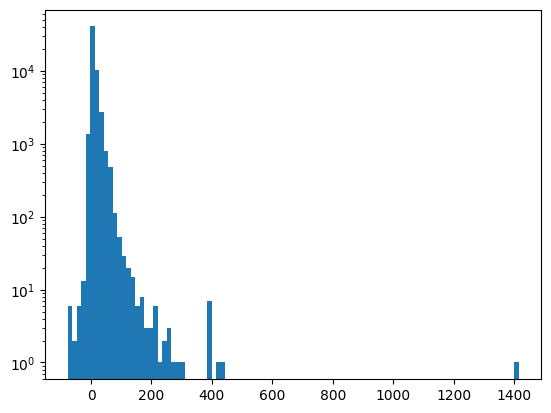

In [15]:
hist(data['fare_amount'], 100)

#### Logical Indexing (Filters)

In [16]:
nonneg = data['fare_amount'] >= 0
print(f'{nonneg.sum() / nonneg.size : .1%} of fares are non-negative')

 99.7% of fares are non-negative


In [17]:
describe(data['fare_amount'][nonneg])

mean: 17.01
std: 15.29
min: 0.00
max: 1422.60


In [18]:
data_nonneg = {k:v[nonneg] for k, v in data.items()}

In [19]:
data_nonneg

{'VendorID': array([2 2 2 ... 2 2 2]),
 'lpep_pickup_datetime': Datetime(['1970-01-20 17:21:10.015000',
           '1970-01-20 17:21:09.102000',
           '1970-01-20 17:21:09.021000',
           ... ,
           '1970-01-20 18:05:36.960000',
           '1970-01-20 18:05:41.100000',
           '1970-01-20 18:05:40.080000'],
          dtype='datetime64[ns]'),
 'lpep_dropoff_datetime': Datetime(['1970-01-20 17:21:10.705000',
           '1970-01-20 17:21:10.354000',
           '1970-01-20 17:21:10.163000',
           ... ,
           '1970-01-20 18:05:37.200000',
           '1970-01-20 18:05:41.460000',
           '1970-01-20 18:05:41.940000'],
          dtype='datetime64[ns]'),
 'fare_amount': array([12.800000000000001 30.300000000000001 19.800000000000001 ... 11.58 14.220000000000001 44.619999999999997])}

#### Time Data

In [20]:
data['ride_duration'] = data['lpep_dropoff_datetime'] - data['lpep_pickup_datetime']

In [21]:
data['ride_duration']

Timedelta(['0 days 00:00:00.690000',
           '0 days 00:00:01.252000',
           '0 days 00:00:01.142000',
           ... ,
           '0 days 00:00:00.240000',
           '0 days 00:00:00.360000',
           '0 days 00:00:01.860000'],
          dtype='timedelta64[ns]')

In [22]:
data['ride_duration'].min(), data['ride_duration'].max()

(Timedelta('0 days 00:00:00'), Timedelta('0 days 00:01:26.339000'))

# TODO: FIX THIShist(data['ride_duration'], 100)

# Taxi Zone Lookup Table

### Use method 1: CSV -> Pandas -> Arkouda

In [26]:
import pandas as pd

def cvt_to_string(v):
    try:
        if v == '':
            return 'N/A'
        else:
            return str(v)
    except:
        return 'N/A'

cvt = {'Borough':cvt_to_string, 'Zone':cvt_to_string, 'service zone':cvt_to_string}
tzlut = pd.read_csv('/Users/ben.mcdonald/data/taxi_zone_lookup.csv', converters=cvt)

top_row = pd.DataFrame({'LocationID': [0], 'Borough': ['N/A'], 'service_zone':['N/A']})
tzlut = pd.concat([top_row, tzlut]).reset_index(drop=True)

In [27]:
tzlut

,LocationID,Borough,service_zone,Zone
0,0,N/A,N/A,NaN
1,1,EWR,EWR,Newark Airport
2,2,Queens,Boro Zone,Jamaica Bay
3,3,Bronx,Boro Zone,Allerton/Pelham Gardens
4,4,Manhattan,Yellow Zone,Alphabet City
...,...,...,...,...
261,261,Manhattan,Yellow Zone,World Trade Center
262,262,Manhattan,Yellow Zone,Yorkville East
263,263,Manhattan,Yellow Zone,Yorkville West
264,264,Unknown,NaN,N/A


#### Convert Pandas DF to Arkouda DF

In [40]:
def ak_create_from_df(df):
    akdict = {}
    for cname in df.keys():
        if df[cname].dtype.name == 'object':
            akdict[cname] = ak.from_series(df[cname],dtype=str)
        else:
            akdict[cname] = ak.from_series(df[cname])
    return ak.DataFrame(akdict)

In [41]:
aktzlut = ak_create_from_df(tzlut)

In [42]:
aktzlut

,LocationID,Borough,service_zone,Zone
0,0,N/A,N/A,nan
1,1,EWR,EWR,Newark Airport
2,2,Queens,Boro Zone,Jamaica Bay
3,3,Bronx,Boro Zone,Allerton/Pelham Gardens
4,4,Manhattan,Yellow Zone,Alphabet City
...,...,...,...,...
261,261,Manhattan,Yellow Zone,World Trade Center
262,262,Manhattan,Yellow Zone,Yorkville East
263,263,Manhattan,Yellow Zone,Yorkville West
264,264,Unknown,nan,N/A


#### Apply Lookup Table

In [43]:
(aktzlut['LocationID'] == ak.arange(aktzlut['LocationID'].size)).all()

True

In [50]:
data['PUBorough'] = aktzlut['Borough'][data['PULocationID']]
data['DOBorough'] = aktzlut['Borough'][data['DOLocationID']]

In [52]:
data['PUZone'] = aktzlut['Zone'][data['PULocationID']]
data['DOZone'] = aktzlut['Zone'][data['DOLocationID']]

In [53]:
data

{'VendorID': array([2 2 2 ... 2 2 2]),
 'lpep_pickup_datetime': array([1704070015000000 1704069102000000 1704069021000000 ... 1706736960000000 1706741100000000 1706740080000000]),
 'lpep_dropoff_datetime': array([1704070705000000 1704070354000000 1704070163000000 ... 1706737200000000 1706741460000000 1706741940000000]),
 'fare_amount': array([12.800000000000001 30.300000000000001 19.800000000000001 ... 11.58 14.220000000000001 44.619999999999997]),
 'PULocationID': array([236 65 74 ... 72 41 33]),
 'DOLocationID': array([239 170 262 ... 72 42 91]),
 'PUBorough': array(['Manhattan', 'Brooklyn', 'Manhattan', ... , 'Brooklyn', 'Manhattan', 'Brooklyn']),
 'DOBorough': array(['Manhattan', 'Manhattan', 'Manhattan', ... , 'Brooklyn', 'Manhattan', 'Brooklyn']),
 'PUZone': array(['Upper East Side North', 'Downtown Brooklyn/MetroTech', 'East Harlem North', ... , 'East Flatbush/Remsen Village', 'Central Harlem', 'Brooklyn Heights']),
 'DOZone': array(['Upper West Side South', 'Murray Hill', 'York

#### GroupBy: Construct a Graph
Define graph from PULocationID -> DOLocationID

In [55]:
byloc = ak.GroupBy([data['PULocationID'], data['DOLocationID']])

In [56]:
byloc.unique_keys

(array([1 3 3 ... 265 265 265]), array([1 132 166 ... 244 264 265]))

In [57]:
(u, v), w = byloc.count()

In [58]:
u, v, w

(array([1 3 3 ... 265 265 265]),
 array([1 132 166 ... 244 264 265]),
 array([3 1 1 ... 1 2 8]))

#### Broadcast: Find Rides with Anomalous Fares
Compute mean and stddev of fare by (pickup, dropoff)

In [60]:
_, mf = byloc.mean(data['fare_amount'])

In [61]:
sf = (byloc.sum(data['fare_amount']**2)[1] / w) - mf**2

Broadcast group values back to ride dataframe to compute z-score of rides

In [63]:
data['fare_mean'] = byloc.broadcast(mf, permute=True)
data['fare_std'] = byloc.broadcast(sf, permute=True)

In [65]:
data['fare_z'] = (data['fare_amount'] - data['fare_mean']) / (data['fare_std'] + 1)

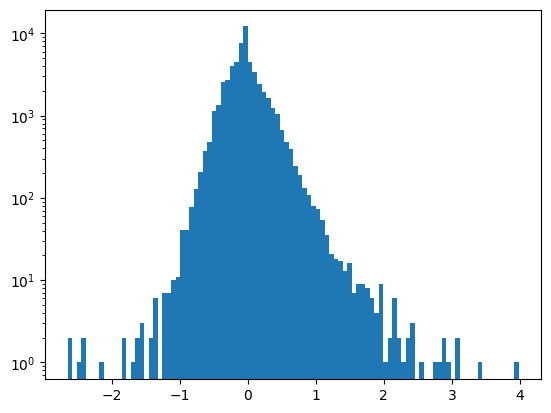

In [66]:
hist(data['fare_z'], 100)

# TODO: This is wrong in the conversion to Panda
#### Bring Small Result Set Back to Pandas

In [72]:
exorbitant = (data['fare_z'] > 3)
exdf = pd.DataFrame({k: v[exorbitant].to_ndarray() for k, v in data.items()})

In [73]:
exdf

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,fare_amount,PULocationID,DOLocationID,PUBorough,DOBorough,PUZone,DOZone,fare_mean,fare_std,fare_z
0,2,1704912105000000,1704914550000000,55.5,74,138,Manhattan,Queens,East Harlem North,LaGuardia Airport,28.216444,6.871561,3.466092
1,1,1706176798000000,1706178607000000,25.4,75,74,Manhattan,Manhattan,East Harlem South,East Harlem North,8.806766,4.324441,3.116427
2,2,1706709366000000,1706711214000000,34.5,74,75,Manhattan,Manhattan,East Harlem North,East Harlem South,10.356889,6.763855,3.109681
3,1,1706711409000000,1706714350000000,41.5,74,75,Manhattan,Manhattan,East Harlem North,East Harlem South,10.356889,6.763855,4.011295


In [74]:
worst = data['fare_z'].argmax()
{k:v[worst] for k, v in data.items()}

{'VendorID': 1,
 'lpep_pickup_datetime': 1706711409000000,
 'lpep_dropoff_datetime': 1706714350000000,
 'fare_amount': 41.5,
 'PULocationID': 74,
 'DOLocationID': 75,
 'PUBorough': 'Manhattan',
 'DOBorough': 'Manhattan',
 'PUZone': 'East Harlem North',
 'DOZone': 'East Harlem South',
 'fare_mean': 10.356889007470594,
 'fare_std': 6.763855476474191,
 'fare_z': 4.011294528459263}

### Disconnect From or Shutdown Server

In [75]:
# ak.disconnect()
# ak.shutdown()